In [10]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [12]:
!pip install tensorflow-addons

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow_addons-0.22.0-cp39-cp39-win_amd64.whl (729 kB)


In [13]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt

C:\Users\pavani Dhanavath\AppData\Roaming\Python\Python39\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\pavani Dhanavath\AppData\Roaming\Python\Python39\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounte

In [17]:
# Load pre-trained VGG19 model
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

In [73]:
# Load and preprocess content and style images
style_path = r"C:\Users\pavani Dhanavath\Downloads\monallisa_2.jpeg" 
content_path = r"C:\Users\pavani Dhanavath\Downloads\WhatsApp Image 2023-11-21 at 11.35.42 PM (1).jpeg"

In [74]:
#  function to Resize images to VGG19 input size. # Add batch dimension
def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (224, 224))  # Resize images to VGG19 input size
    img = img[tf.newaxis, :]  # Add batch dimension
    return img

In [75]:
# resizing our images to VGG19 size and Batch dimention 
content_image = load_and_preprocess_image(content_path)
style_image = load_and_preprocess_image(style_path)

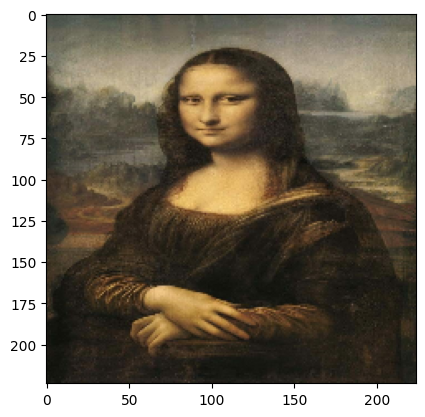

In [76]:
plt.imshow(np.squeeze(style_image))
plt.show()

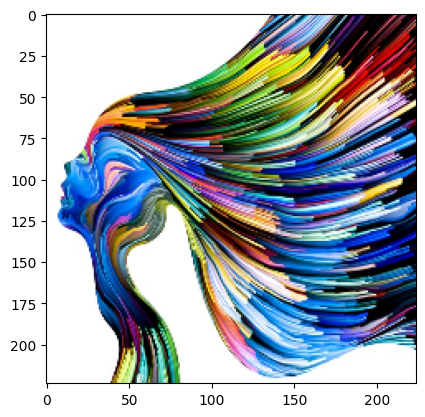

In [77]:
plt.imshow(np.squeeze(content_image))
plt.show()

In [78]:
# Define a custom model to extract specific VGG19 layers for content and style representations
content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

In [79]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model(inputs=vgg.input, outputs=outputs)
    return model

In [80]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}


In [81]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

In [82]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [83]:
# Define the total variation loss for regularization
def total_variation_loss(image):
    x_deltas = image[:, :-1, :] - image[:, 1:, :]
    y_deltas = image[:-1, :, :] - image[1:, :, :]
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [84]:
# Define style and content weights
style_weight = 1e-2
content_weight = 1e4
tv_weight = 30


In [85]:
#Define the optimizer
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [86]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        style_outputs = outputs['style']
        content_outputs = outputs['content']

        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
                               for name in style_outputs.keys()])
        style_loss *= style_weight / len(style_layers)

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
                                 for name in content_outputs.keys()])
        content_loss *= content_weight / len(content_layers)

        tv_loss = total_variation_loss(image) * tv_weight

        total_loss = style_loss + content_loss + tv_loss

    grad = tape.gradient(total_loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

In [87]:
# Generate the stylized image
stylized_image = tf.Variable(content_image)


In [88]:
epochs = 10
for i in range(epochs):
    train_step(stylized_image)


In [89]:
# Convert the image tensor back to numpy array for SSIM calculation
generated_image = np.squeeze(stylized_image.numpy(), axis=0)


In [90]:
# Calculate SSIM between generated image and style image
ssim_value = tf.image.ssim(tf.convert_to_tensor(generated_image), style_image, max_val=1.0)


In [91]:
print(ssim_value)

tf.Tensor([0.0570278], shape=(1,), dtype=float32)


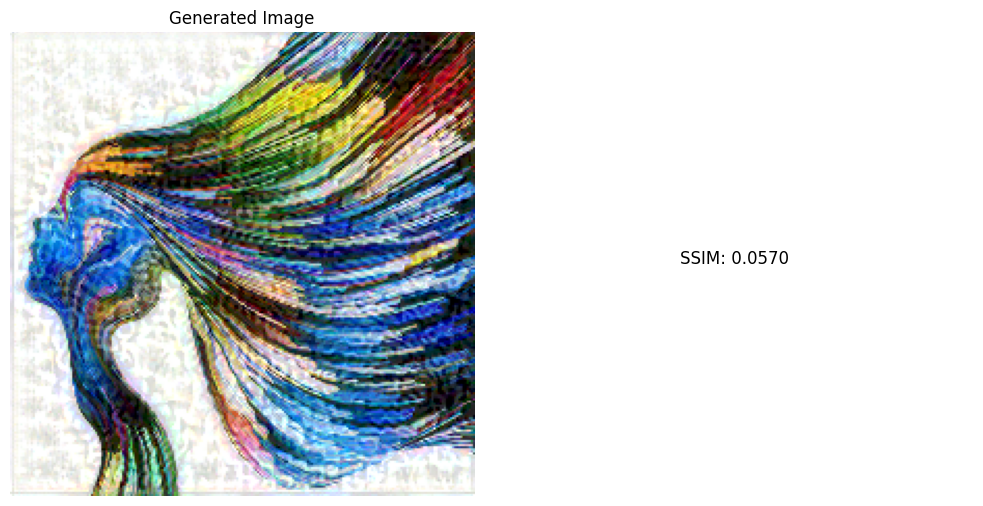

In [92]:
# Display the generated image and SSIM value
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(generated_image)
plt.title('Generated Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.text(0.5, 0.5, f'SSIM: {float(ssim_value):.4f}', fontsize=12, ha='center')

plt.axis('off')

plt.tight_layout()
plt.show()
